In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
base_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily_run'

In [3]:
### Adding the landcover data that I did the bankbuffer scenario with

landcover_bankbuffer = pd.read_csv(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\base_hsfiles_bankbuffer6m\inputs\WFK23_lcdata.csv')

In [4]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
#obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [5]:
obs_clip

,18.3,17.5,16.1,14.9,13.8,12.2,10.7,8.5,8.0,7.2,5.7,2.7,2.3,1.2,0.0
datetime,,,,,,,,,,,,,,,
2023-07-01 00:00:00,20.817,20.293,20.770,21.461,21.342,20.889,21.199,21.700,20.579,20.579,21.437,22.250,22.106,21.867,21.939
2023-07-01 01:00:00,20.484,19.888,20.365,21.032,20.984,20.579,20.865,21.461,20.341,20.246,21.008,21.963,21.819,21.604,21.748
2023-07-01 02:00:00,20.150,19.579,19.984,20.674,20.603,20.293,20.555,21.199,20.079,19.984,20.627,21.676,21.557,21.342,21.533
2023-07-01 03:00:00,19.841,19.270,19.651,20.293,20.198,20.007,20.269,20.913,19.817,19.746,20.246,21.342,21.223,21.079,21.294
2023-07-01 04:00:00,19.484,18.937,19.270,19.912,19.817,19.651,19.960,20.555,19.532,19.460,19.912,20.960,20.865,20.793,21.008
2023-07-01 05:00:00,19.246,18.675,18.985,19.579,19.508,19.294,19.674,20.246,19.246,19.199,19.651,20.603,20.484,20.460,20.746
2023-07-01 06:00:00,19.032,18.461,18.771,19.318,19.246,19.032,19.436,20.031,19.032,18.961,19.413,20.269,20.174,20.150,20.507
2023-07-01 07:00:00,18.889,18.319,18.652,19.151,19.056,18.842,19.222,19.888,18.937,18.818,19.246,20.031,19.912,19.912,20.269
2023-07-01 08:00:00,18.937,18.343,18.699,19.127,19.008,18.794,19.127,19.865,18.985,18.794,19.151,19.912,19.746,19.770,20.150


In [6]:
notopo_shade_df = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily', 'outputs', 'Shade.csv'), skiprows=6,
         usecols=range(1, 185))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)

notopo_shade_df[(notopo_shade_df['NODE_ID'] <= 18.3) & (notopo_shade_df['NODE_ID']>=10)]


,NODE_ID,July Shade
0,18.3,0.4166
1,18.2,0.2887
2,18.1,0.3402
3,18.0,0.0712
4,17.9,0.0719
...,...,...
79,10.4,0.0533
80,10.3,0.0250
81,10.2,0.0546
82,10.1,0.2385


In [10]:
## Scenario Type
landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))

changed_nodes = {}

#for index, row in landcover.iterrows():
original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily_run'
# folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
# new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_shade\\shadeallnodes" 
shutil.copytree(original_folder_path, new_folder_path)

control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

landcover_km = landcover.copy()# Create a copy of landcover DataFrame
morphology_km = morphology.copy()# Create a copy of morphology DataFrame
#landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
reach_shade = notopo_shade_df#[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
##print(km_start)
    #changed_nodes[km_start] = []

#loop to increase shade at each node, increase width only where its currently grassy

for index, row in reach_shade.iterrows():
    #assigns bankbuffer shade to each node
    landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
    morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)

    # only widens currently grassy nodes
    if reach_shade.loc[index]['July Shade'] < .2:
        print('changin to shade @: ', index)


        #if you want to only increase shade at previouslt grassy nodes, uncomment the below line
        # landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]

        #widening currently grassy reaches by 20% when changed to trees
        morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2

        landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            #morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            # changed_nodes[km_start].append(index)

os.chdir(new_folder_path)
subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

changin to shade @:  3
changin to shade @:  4
changin to shade @:  5
changin to shade @:  8
changin to shade @:  9
changin to shade @:  10
changin to shade @:  11
changin to shade @:  12
changin to shade @:  13
changin to shade @:  14
changin to shade @:  15
changin to shade @:  16
changin to shade @:  17
changin to shade @:  19
changin to shade @:  24
changin to shade @:  25
changin to shade @:  32
changin to shade @:  35
changin to shade @:  36
changin to shade @:  38
changin to shade @:  39
changin to shade @:  40
changin to shade @:  43
changin to shade @:  44
changin to shade @:  46
changin to shade @:  47
changin to shade @:  49
changin to shade @:  50
changin to shade @:  51
changin to shade @:  52
changin to shade @:  57
changin to shade @:  58
changin to shade @:  59
changin to shade @:  60
changin to shade @:  65
changin to shade @:  66
changin to shade @:  67
changin to shade @:  68
changin to shade @:  69
changin to shade @:  71
changin to shade @:  72
changin to shade @:  

CompletedProcess(args=['hs', 'run', '-t'], returncode=0)

In [11]:
base_tw_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
base_tw_df.columns = [float(col) for col in base_tw_df.columns]
base_tw_df.index = obs_clip.index
#mean july
mean_daily_base = base_tw_df.resample('D').mean()
mean_july_base = base_tw_df.mean()
mean_base = pd.DataFrame(mean_july_base)
mean_base = mean_base.reset_index()
mean_base.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_base['distance downstream'] = 18.3 - mean_base['NODE_ID']


allshade_tw_df = pd.read_csv(os.path.join(new_folder_path, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
allshade_tw_df.columns = [float(col) for col in allshade_tw_df.columns]
allshade_tw_df.index = obs_clip.index
#mean july
mean_allshade = allshade_tw_df.resample('D').mean()
mean_allshade = mean_allshade.mean()
mean_allshade

mean_allshade = pd.DataFrame(mean_allshade)
mean_allshade = mean_allshade.reset_index()
mean_allshade.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_allshade['distance downstream'] = 18.3 - mean_allshade['NODE_ID']


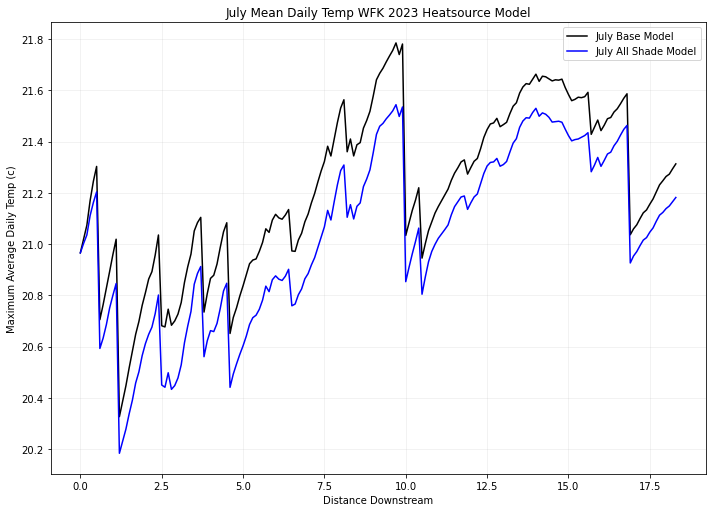

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(mean_base.index/10, mean_base['Mean'], label='July Base Model', color = 'black')
plt.plot(mean_allshade.index/10, mean_allshade['Mean'], label='July All Shade Model', color = 'blue')

#plt.plot(max_dailymean_scenario.index/10,max_dailymean_scenario['Max Daily Mean July Temp'],  label = 'Shade Scenario Model')


plt.ylabel('Maximum Average Daily Temp (c)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(21, 25)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('July Mean Daily Temp WFK 2023 Heatsource Model')
plt.savefig('JulyDailyMean_withobstribQ.png')
plt.show()
